### 数据获取

In [ ]:
# 下载文件
!wget http://tianchi-media.oss-cn-beijing.aliyuncs.com/dragonball/DL/other/data/Emotion_Recognition_File.zip

In [ ]:
# 解压文件
!unzip -q -o ./Emotion_Recognition_File.zip -d Emotion_Recognition_File/

#### 文件夹说明
img_type_test：放置了不同后缀名的图片，在 3.1 图片格式统一 将会使用到  
face_detect_model：放置了人脸检测所需要的模型，在 3.2 数据清洗、3.3 提取嘴唇区域 将会使用到  
face_det_img：放置了一些包含人脸的图片和不包含人人脸的图片，在 3.2 数据清洗 将会使用到  
mouth_det_img：放置了一些包含人脸的图片，在 3.3 提取嘴唇区域 将会使用到  
train_val_data：放置了本训练营为各位读者准备的数据集，将会在下一个 Task 用到  
test_img：放置了包含 4 种表情的图片各一张，将会在下一个 Task 用到，我们就是使用这个文件夹里的图片来展示我们的成果

## 项目背景
⼈脸表情识别(facial expression recognition, FER)作为⼈脸识别技术中的⼀个重要组成部分，近年来在⼈机交互、安全、机器⼈制造、⾃动化、医疗、通信和驾驶领域得到了⼴泛的关注，成为学术界和⼯业界的研究热点，是⼈脸属性分析的重点。

### 数据获取
1. 爬虫爬取图像  
    使用爬虫工具 https://github.com/QianyanTech/Image-Downloader 下载图像  
    其他爬虫工具：https://mp.weixin.qq.com/s/75QDjRTDCKzuM68L4fg5Lg

2. 对获取的图像进行数据整理，包括重命名、格式统一
3. 利用人脸检测算法删选出有用的样本，利用关键点检测算法裁剪出用于算法训练的嘴唇区域

### 数据整理
#### 图像格式统一
读取不同格式的图像，统一转换为jpg, 同时删除原来的图像

In [ ]:
import os
import cv2

def img_format_files(root_path, exp='.jpg'):
    """_summary_ 将不同格式的图像转换为统一格式

    Args:
        root_path (_type_): _description_ 文件路径
        exp (str, optional): _description_. 默认转换为 '.jpg'.
    """
    list_dirs = os.walk(root_path)
    for root, dirs, files in list_dirs:  # 遍历文件夹中的文件
        for d in dirs:
            print(os.path.join(root, d))
        for f in files:
            file_id = f.split('.')[0]  # 获取图像的名字，不含后缀
            file_path = os.path.join(root, f)
            print(file_path)
            try:
                img = cv2.imread(file_path, 1)  # 读取原始图像，数据加载到内存
                print('img src: ', file_path, img.shape)
                os.remove(file_path)  # 删除原始图像
                cv2.imwrite(os.path.join(root, file_id + exp), img)  # 保存格式转换后的图像
            except:
                os.remove(file_path)
                continue

path = './data/Emotion_Recognition_File/img_type_test'
img_format_files(path)
                

### 数据清洗
删除不符合的图像，这里删除非人脸的图像  
使用 **opencv 自带的 haarcascade_frontalface 进行人脸检测**

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt

def face_classify(img_path):
    """_summary_ 使用opencv自带人脸检测算法检测人脸

    Args:
        img_path (_type_): _description_
    """
    # opencv 自带的人脸检测模型
    cascade_path = './data/Emotion_Recognition_File/face_detect_model/haarcascade_frontalface_default.xml'
    cascade = cv2.CascadeClassifier(cascade_path)
    images = os.listdir(img_path)
    for image in images:
        img = cv2.imread(os.path.join(img_path, image), 1)  # 读取图像
        rects = cascade.detectMultiScale(img, 1.5, 5)  # 检测人脸
        print('检测到人脸的数量：', len(rects))
        if len(rects) == 0:  # 检测人脸的数量为0，没有检测到人脸的话，会显示出图片，适合本地调试使用，在服务器上可能不会显示
            # cv2.nameWindow('result', 0)
            # cv2.imshow('result', img)
            # print('没有检测到人脸')
            # os.remove(os.path.join(img_path, image))
            # k = cv2.waitKey(0)
#           if k == ord('q'): # 在英文状态下，按下按键 q 会关闭显示窗口    
#               break
#           print()
#           cv2.destroyAllWindows()  
            pass
        plt.imshow(img[:, :, ::-1])
        plt.show()
        
face_classify('./data/Emotion_Recognition_File/img_type_test')

# 这里使用的是 opencv 自带的模型，效果并不好，召回率不高，因此会有一些好的样本被删除

### 提取嘴唇区域并形成数据集
处理数据，达到真正训练所需要的图像，本任务只对嘴唇部分的表情进行识别，所以目标就是获取人脸嘴唇附近区域的图像，然后进行分类。  
使用 **opencv + Dlib** 算法提取嘴唇区域，Dlib 算法会得到人脸的 68 个关键点，从中共得到嘴唇区域，并适当扩大  

> 注意：这里使用的是 Dlib 算法，所以需要先安装 Dlib，直接 pip 安装可能会报错，下载对应版本的 whl 文件进行安装 python -m pip install dlib-19.22.1-cp39-cp39m-win_amd64.whl 进行安装  
> 不同python版本的dlib whl文件： https://github.com/Silufer/dlib-python  

获取嘴唇区域后，将不同类型的数据存放到不同文件夹，形成数据集  
例如：四个文件夹
- 0none
- 1pouting
- 2smile
- 3openmouth 



人脸的 68 个关键点
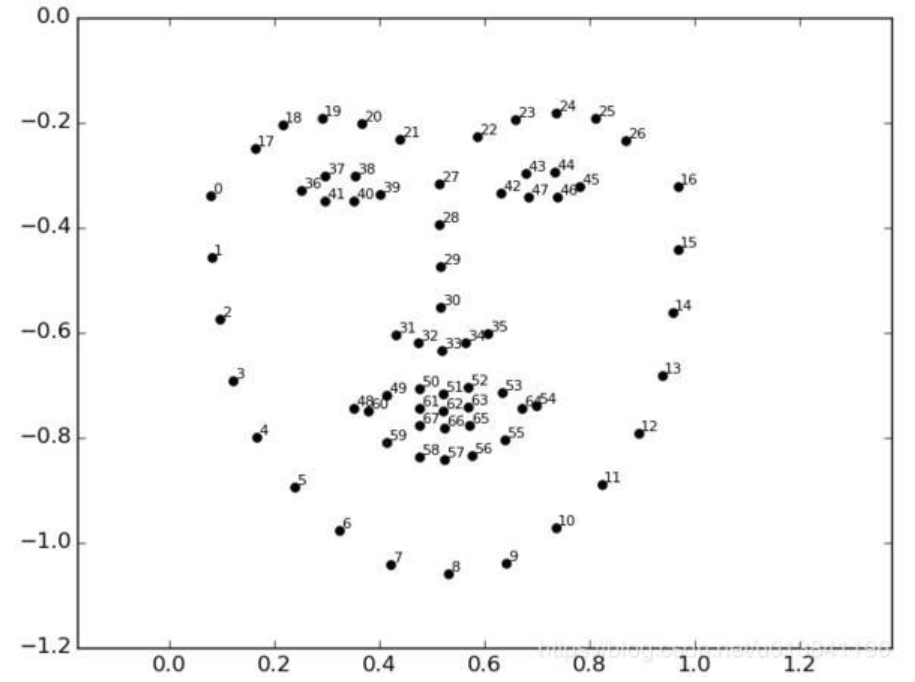

In [ ]:
import cv2
import dlib
import numpy as np
import os
import matplotlib.pyplot as plt

# 配置dlib 关键点检测路径，可从http://dlib.net/files/ 下载
PREDICTOR_PATH = "./data/Emotion_Recognition_File/face_detect_model/shape_predictor_68_face_landmarks.dat"
predictor = dlib.shape_predictor(PREDICTOR_PATH)
# 配置人脸检测器路径
cascade_path = './data/Emotion_Recognition_File/face_detect_model/haarcascade_frontalface_default.xml'
cascade = cv2.CascadeClassifier(cascade_path)

def get_landmarks(img):
    rects = cascade.detectMultiScale(img, 1.3 ,5)  # 检测人脸
    x, y, w, h = rects[0]  # 获取人脸的四个属性值，左上角坐标x,y 高宽w,h
    # print(x, y, w, h)
    rect = dlib.rectangle(int(x), int(y), int(x+w), int(y+h))
    return np.matrix([[p.x, p.y] for p in predictor(img, rect).parts()])

def annotate_landmarks(img, landmarks):
    img = img.copy()
    for idx, point in enumerate(landmarks):
        pos = (point[0, 0], point[0, 1])
        cv2.putText(img,
                    str(idx),
                    pos,
                    fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
                    fontScale=0.4,
                    color=(0, 0, 255))
        cv2.circle(img, pos, 5, color=(0, 255, 255))
    return img

def getlipfromimg(img, landmarks):
    xmin = 10000
    xmax = 0
    ymin = 10000
    ymax = 0
    # 根据最外围的关键点获取包围嘴唇的最小矩形框
    # 68 个关键点是从
    # 左耳朵0 -下巴-右耳朵16-左眉毛（17-21）-右眉毛（22-26）-左眼睛（36-41）
    # 右眼睛（42-47）-鼻子从上到下（27-30）-鼻孔（31-35）
    # 嘴巴外轮廓（48-59）嘴巴内轮廓（60-67）
    for i in range(48, 67):
        x = landmarks[i, 0]
        y = landmarks[i, 1]
        if x < xmin:
            xmin = x
        if x > xmax:
            xmax = x
        if y < ymin:
            ymin = y
        if y > ymax:
            ymax = y

    print("xmin=", xmin)
    print("xmax=", xmax)
    print("ymin=", ymin)
    print("ymax=", ymax)

    roiwidth = xmax - xmin
    roiheight = ymax - ymin
    roi = img[ymin:ymax, xmin:xmax, 0:3]

    if roiwidth > roiheight:
        dstlen = 1.5 * roiwidth
    else:
        dstlen = 1.5 * roiheight

    diff_xlen = dstlen - roiwidth
    diff_ylen = dstlen - roiheight

    newx = xmin
    newy = ymin

    imagerows, imagecols, channel = img.shape
    if newx >= diff_xlen / 2 and newx + roiwidth + diff_xlen / 2 < imagecols:
        newx = newx - diff_xlen / 2
    elif newx < diff_xlen / 2:
        newx = 0    
    else:
        newx = imagecols - dstlen

    if newy >= diff_ylen / 2 and newy + roiheight + diff_ylen / 2 < imagerows:
        newy = newy - diff_ylen / 2
    elif newy < diff_ylen / 2:
        newy = 0
    else:
        newy = imagerows - dstlen

    roi = img[int(newy):int(newy + dstlen), int(newx):int(newx + dstlen), 0:3]
    return roi

def list_files(rootDir):
    list_dirs = os.walk(rootDir)
    for root, dirs, files in list_dirs:
        for d in dirs:
            print(os.path.join(root, d))
        for f in files:
            file_id = f.split('.')[0]

            file_path = os.path.join(root, f)
            try:
                im = cv2.imread(file_path, 1)
                landmarks = get_landmarks(im)
                roi = getlipfromimg(im, landmarks)
                roi_path = file_path.replace('.jpg', '_mouth.png')
                # cv2.imwrite(roi_path, roi)
                plt.imshow(roi[:, :, ::-1])
                plt.show()
            except:
                # print("error")
                continue
            
list_files('./data/Emotion_Recognition_File/mouth_det_img/')

## 模型搭建
整个训练流程包括数据接口准备、模型定义、结果保存与分析
### 1.数据接口准备
PyTorch 图像分类直接利用文件夹作为输入，只需要把不同类的数据放到不同的文件夹中  
- 输入一个文件夹，输出图片路径以及标签，在开始训练之前需要将数据集进行拆分，拆分成训练集(train)和验证集(val)，训练集和测试集的比例为9:1，train_val_data文件结构如下所示，其中 0 代表 none、 1 代表pouting、2 代表 smile、3 代表 openmouth

- train_val_data
  - train
    - 0
    - 1
    - 2
    - 3
  - val
    - 0
    - 1
    - 2
    - 3

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(48),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
    ]),
    'val': transforms.Compose([
        transforms.Scale(64),
        transforms.CenterCrop(48),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
    ]),
}

data_dir = './train_val_data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'val']}

dataloders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                             batch_size=16,
                                             shuffle=True,
                                             num_workers=4) for x in ['train', 'val']}

### 2.模型定义

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class simpleconv3(nn.Module):
    def __init__(self):
        super(simpleconv3,self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, 2)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(12, 24, 3, 2)
        self.bn2 = nn.BatchNorm2d(24)
        self.conv3 = nn.Conv2d(24, 48, 3, 2)
        self.bn3 = nn.BatchNorm2d(48)
        self.fc1 = nn.Linear(48 * 5 * 5 , 1200)
        self.fc2 = nn.Linear(1200 , 128)
        self.fc3 = nn.Linear(128 , 4)

    def forward(self , x):
        x = F.relu(self.bn1(self.conv1(x)))
        #print "bn1 shape",x.shape
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(-1 , 48 * 5 * 5) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 3.模型训练

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import time
import os
from tensorboardX import SummaryWriter
import torch.nn.functional as F
import numpy as np
import warnings

warnings.filterwarnings('ignore')

writer = SummaryWriter()

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()    
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0

            for data in dataloders[phase]:
                inputs, labels = data
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data.item()
                running_corrects += torch.sum(preds == labels).item()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
           
            if phase == 'train':
                writer.add_scalar('data/trainloss', epoch_loss, epoch)
                writer.add_scalar('data/trainacc', epoch_acc, epoch)
            else:
                writer.add_scalar('data/valloss', epoch_loss, epoch)
                writer.add_scalar('data/valacc', epoch_acc, epoch)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

    writer.export_scalars_to_json("./all_scalars.json")
    writer.close()
    return model

In [ ]:
if __name__ == '__main__':

    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomSizedCrop(48),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
        ]),
        'val': transforms.Compose([
            transforms.Scale(64),
            transforms.CenterCrop(48),
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
        ]),
    }

    data_dir = './data/Emotion_Recognition_File/train_val_data/' # 数据集所在的位置
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x]) for x in ['train', 'val']}
    dataloders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                                 batch_size=64,
                                                 shuffle=True if x=="train" else False,
                                                 num_workers=8) for x in ['train', 'val']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

    use_gpu = torch.cuda.is_available()
    print("是否使用 GPU", use_gpu)
    modelclc = simpleconv3()
    print(modelclc)
    if use_gpu:
        modelclc = modelclc.cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.SGD(modelclc.parameters(), lr=0.1, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=100, gamma=0.1)

    modelclc = train_model(model=modelclc,
                           criterion=criterion,
                           optimizer=optimizer_ft,
                           scheduler=exp_lr_scheduler,
                           num_epochs=10)  # 这里可以调节训练的轮次
    if not os.path.exists("models"):
        os.mkdir('models')
    torch.save(modelclc.state_dict(),'models/model.ckpt')

### 4.模型测试
测试模型，并可视化图像

In [ ]:
import numpy as np
import cv2
import os
import dlib
import torch
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import time
from PIL import Image
import torch.nn.functional as F

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')


PREDICTOR_PATH = "./data/Emotion_Recognition_File/face_detect_model/shape_predictor_68_face_landmarks.dat"
predictor = dlib.shape_predictor(PREDICTOR_PATH)
cascade_path = './data/Emotion_Recognition_File/face_detect_model/haarcascade_frontalface_default.xml'
cascade = cv2.CascadeClassifier(cascade_path)

if not os.path.exists("results"):
    os.mkdir("results")
    

def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma

def get_landmarks(im):
    rects = cascade.detectMultiScale(im, 1.3, 5)
    x, y, w, h = rects[0]
    rect = dlib.rectangle(int(x), int(y), int(x + w), int(y + h))
    return np.matrix([[p.x, p.y] for p in predictor(im, rect).parts()])


def annotate_landmarks(im, landmarks):
    im = im.copy()
    for idx, point in enumerate(landmarks):
        pos = (point[0, 0], point[0, 1])
        cv2.putText(im,
                    str(idx),
                    pos,
                    fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
                    fontScale=0.4,
                    color=(0, 0, 255))
        cv2.circle(im, pos, 3, color=(0, 255, 255))
    return im


testsize = 48  # 测试图大小

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
net = simpleconv3()
net.eval()
modelpath = "./models/model.ckpt"  # 模型路径
net.load_state_dict(
    torch.load(modelpath, map_location=lambda storage, loc: storage))

# 一次测试一个文件
img_path = "./Emotion_Recognition_File/find_face_img/"
imagepaths = os.listdir(img_path)  # 图像文件夹

for imagepath in imagepaths:
    im = cv2.imread(os.path.join(img_path, imagepath), 1)
    try:
        rects = cascade.detectMultiScale(im, 1.3, 5)
        x, y, w, h = rects[0]
        rect = dlib.rectangle(int(x), int(y), int(x + w), int(y + h))
        landmarks = np.matrix([[p.x, p.y]
                               for p in predictor(im, rect).parts()])
    except:
#         print("没有检测到人脸")
        continue  # 没有检测到人脸

    xmin = 10000
    xmax = 0
    ymin = 10000
    ymax = 0

    for i in range(48, 67):
        x = landmarks[i, 0]
        y = landmarks[i, 1]
        if x < xmin:
            xmin = x
        if x > xmax:
            xmax = x
        if y < ymin:
            ymin = y
        if y > ymax:
            ymax = y

    roiwidth = xmax - xmin
    roiheight = ymax - ymin

    roi = im[ymin:ymax, xmin:xmax, 0:3]

    if roiwidth > roiheight:
        dstlen = 1.5 * roiwidth
    else:
        dstlen = 1.5 * roiheight

    diff_xlen = dstlen - roiwidth
    diff_ylen = dstlen - roiheight

    newx = xmin
    newy = ymin

    imagerows, imagecols, channel = im.shape
    if newx >= diff_xlen / 2 and newx + roiwidth + diff_xlen / 2 < imagecols:
        newx = newx - diff_xlen / 2
    elif newx < diff_xlen / 2:
        newx = 0
    else:
        newx = imagecols - dstlen

    if newy >= diff_ylen / 2 and newy + roiheight + diff_ylen / 2 < imagerows:
        newy = newy - diff_ylen / 2
    elif newy < diff_ylen / 2:
        newy = 0
    else:
        newy = imagecols - dstlen

    roi = im[int(newy):int(newy + dstlen), int(newx):int(newx + dstlen), 0:3]
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    roiresized = cv2.resize(roi,
                            (testsize, testsize)).astype(np.float32) / 255.0
    imgblob = data_transforms(roiresized).unsqueeze(0)
    imgblob.requires_grad = False
    imgblob = Variable(imgblob)
    torch.no_grad()
    predict = F.softmax(net(imgblob))
    print(predict)
    index = np.argmax(predict.detach().numpy())

    im_show = cv2.imread(os.path.join(img_path, imagepath), 1)
    im_h, im_w, im_c = im_show.shape
    pos_x = int(newx + dstlen)
    pos_y = int(newy + dstlen)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.rectangle(im_show, (int(newx), int(newy)),
                  (int(newx + dstlen), int(newy + dstlen)), (0, 255, 255), 2)
    if index == 0:
        cv2.putText(im_show, 'none', (pos_x, pos_y), font, 1.5, (0, 0, 255), 2)
    if index == 1:
        cv2.putText(im_show, 'pout', (pos_x, pos_y), font, 1.5, (0, 0, 255), 2)
    if index == 2:
        cv2.putText(im_show, 'smile', (pos_x, pos_y), font, 1.5, (0, 0, 255), 2)
    if index == 3:
        cv2.putText(im_show, 'open', (pos_x, pos_y), font, 1.5, (0, 0, 255), 2)
#     cv2.namedWindow('result', 0)
#     cv2.imshow('result', im_show)
    cv2.imwrite(os.path.join('results', imagepath), im_show)
#     print(os.path.join('results', imagepath))
    plt.imshow(im_show[:, :, ::-1])  # 这里需要交换通道，因为 matplotlib 保存图片的通道顺序是 RGB，而在 OpenCV 中是 BGR
    plt.show()
#     cv2.waitKey(0)
# cv2.destroyAllWindows()